# makemore: part 5

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

%matplotlib inline

In [2]:
# read in all the words
words = open("names.txt", "r").read().splitlines()
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [3]:
len(words)

32033

In [4]:
chars = sorted(list(set("".join(words))))
stoi = {s: i + 1 for i, s in enumerate(chars)}
stoi["."] = 0
itos = {i: s for s, i in stoi.items()}
vocab_size = len(itos)
itos

{1: 'a',
 2: 'b',
 3: 'c',
 4: 'd',
 5: 'e',
 6: 'f',
 7: 'g',
 8: 'h',
 9: 'i',
 10: 'j',
 11: 'k',
 12: 'l',
 13: 'm',
 14: 'n',
 15: 'o',
 16: 'p',
 17: 'q',
 18: 'r',
 19: 's',
 20: 't',
 21: 'u',
 22: 'v',
 23: 'w',
 24: 'x',
 25: 'y',
 26: 'z',
 0: '.'}

In [15]:
# build the dataset
block_size = (
    8  # context length: how many characters do we take to predict the next one?
)


def build_dataset(words):
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + ".":
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y


import random

random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])  # 80%
Xdev, Ydev = build_dataset(words[n1:n2])  # 10%
Xtest, Ytest = build_dataset(words[n2:])  # 10%

torch.Size([182580, 8]) torch.Size([182580])
torch.Size([22767, 8]) torch.Size([22767])
torch.Size([22799, 8]) torch.Size([22799])


In [16]:
for x, y in zip(Xtr[:20], Ytr[:20]):
    print("".join(itos[ix.item()] for ix in x), "-->", itos[y.item()])

........ --> e
.......e --> b
......eb --> r
.....ebr --> i
....ebri --> m
...ebrim --> a
..ebrima --> .
........ --> h
.......h --> i
......hi --> l
.....hil --> t
....hilt --> o
...hilto --> n
..hilton --> .
........ --> j
.......j --> h
......jh --> e
.....jhe --> n
....jhen --> e
...jhene --> .


In [36]:
# Let's train a deeper network


class Linear:

    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])


# ------------------------------------------------------------------------------------------


class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # parameters (trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffers (trained with a running average)
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        if self.training:
            if x.ndim == 2:
                dim = 0
            elif x.ndim == 3:
                dim = (0, 1)
            else:
                raise ValueError(f"Unsupported input dimension: {x.ndim}")
            xmean = x.mean(dim=dim, keepdim=True)
            xvar = x.var(dim=dim, keepdim=True, unbiased=True)
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma * xhat + self.beta
        # update running mean and var
        if self.training:
            with torch.no_grad():
                self.running_mean = (
                    1 - self.momentum
                ) * self.running_mean + self.momentum * xmean
                self.running_var = (
                    1 - self.momentum
                ) * self.running_var + self.momentum * xvar

        return self.out

    def parameters(self):
        return [self.gamma, self.beta]


# ------------------------------------------------------------------------------------------


class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out

    def parameters(self):
        return []


# ------------------------------------------------------------------------------------------


class Embedding:
    def __init__(self, num_embeddings, embedding_dim):
        self.weight = torch.randn((num_embeddings, embedding_dim))

    def __call__(self, ix):
        self.out = self.weight[ix]
        return self.out

    def parameters(self):
        return [self.weight]


# ------------------------------------------------------------------------------------------


class FlattenConsecutive:
    def __init__(self, n):
        self.n = n

    def __call__(self, x):
        B, T, C = x.shape
        x = x.view(B, T // self.n, self.n * C)
        if x.shape[1] == 1:
            x = x.squeeze(1)
        self.out = x
        return self.out

    def parameters(self):
        return []


# ------------------------------------------------------------------------------------------


class Sequential:
    def __init__(self, layers):
        self.layers = layers

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return self.out

    def parameters(self):
        # get parameters from all layers and stretch them out into one list
        return [p for layer in self.layers for p in layer.parameters()]

In [37]:
torch.manual_seed(42)

In [47]:
n_embd = 24  # the dimensionality of the character embedding vectors
n_hidden = 128  # the number of neurons in the hidden layer of the MLP

model = Sequential(
    [
        Embedding(vocab_size, n_embd),
        FlattenConsecutive(2),
        Linear(n_embd * 2, n_hidden, bias=False),
        BatchNorm1d(n_hidden),
        Tanh(),
        FlattenConsecutive(2),
        Linear(n_hidden * 2, n_hidden, bias=False),
        BatchNorm1d(n_hidden),
        Tanh(),
        FlattenConsecutive(2),
        Linear(n_hidden * 2, n_hidden, bias=False),
        BatchNorm1d(n_hidden),
        Tanh(),
        Linear(n_hidden, vocab_size),
    ]
)

with torch.no_grad():
    # last layer: make less confident
    model.layers[-1].weight *= 0.1

parameters = model.parameters()
print(sum(p.nelement() for p in parameters))  # number of parameters in total
for p in parameters:
    p.requires_grad = True

76579


In [48]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in tqdm(range(max_steps)):
    # minibatch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]

    # forward pass
    logits = model(Xb)
    loss = F.cross_entropy(logits, Yb)

    # backward pass
    # for layer in layers:
    #     layer.out.retain_grad()  # AFTER_DEBUG: would take out retain_grad()
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0:
        print(f"{i:7d}/{max_steps:7d} loss: {loss.item():.4f}")
    lossi.append(loss.log10().item())

    with torch.no_grad():
        ud.append(
            [(lr * p.grad.std() / p.data.std()).log10().item() for p in parameters]
        )
    # if i > 1000:
    #     break  # AFTER_DEBUG: would take out.
print(loss.item())

  0%|          | 0/200000 [00:00<?, ?it/s]

      0/ 200000 loss: 3.2855
  10000/ 200000 loss: 1.7332
  20000/ 200000 loss: 1.6820
  30000/ 200000 loss: 1.8623
  40000/ 200000 loss: 2.0299
  50000/ 200000 loss: 2.0246
  60000/ 200000 loss: 1.8134
  70000/ 200000 loss: 2.3552
  80000/ 200000 loss: 2.1756
  90000/ 200000 loss: 1.8821
 100000/ 200000 loss: 1.8310
 110000/ 200000 loss: 1.8834
 120000/ 200000 loss: 1.9193
 130000/ 200000 loss: 1.6614
 140000/ 200000 loss: 2.5465
 150000/ 200000 loss: 1.8434
 160000/ 200000 loss: 1.8502
 170000/ 200000 loss: 1.8565
 180000/ 200000 loss: 1.8900
 190000/ 200000 loss: 2.1853
1.7050697803497314


In [49]:
for layer in model.layers:
    print(layer.__class__.__name__, ":", tuple(layer.out.shape))

Embedding : (32, 8, 24)
FlattenConsecutive : (32, 4, 48)
Linear : (32, 4, 128)
BatchNorm1d : (32, 4, 128)
Tanh : (32, 4, 128)
FlattenConsecutive : (32, 2, 256)
Linear : (32, 2, 128)
BatchNorm1d : (32, 2, 128)
Tanh : (32, 2, 128)
FlattenConsecutive : (32, 256)
Linear : (32, 128)
BatchNorm1d : (32, 128)
Tanh : (32, 128)
Linear : (32, 27)


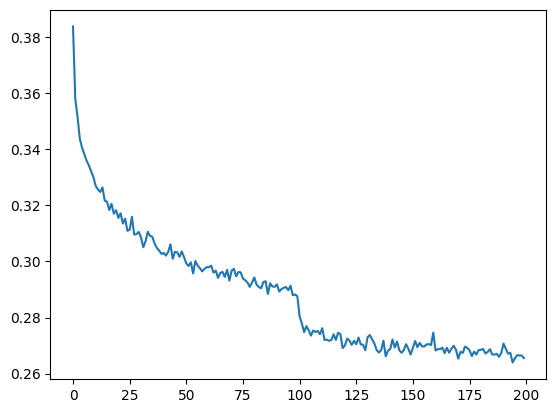

In [50]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))

In [51]:
# Put layers into eval mode (needed for BatchNorm1d)
for layer in model.layers:
    layer.training = False

In [52]:
@torch.no_grad()
def split_loss(split):
    x, y = {"train": (Xtr, Ytr), "val": (Xdev, Ydev), "test": (Xtest, Ytest)}[split]
    logits = model(x)
    loss = F.cross_entropy(logits, y)
    print(f"{split}: {loss.item():.4f}")


split_loss("train")
split_loss("val")

train: 1.8235
val: 1.9877


In [53]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 2)

for _ in range(30):
    out = []
    context = [0] * block_size  # initialize with all ...
    while True:
        logits = model(torch.tensor([context]))  # (1, block_size)
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    print("".join(itos[i] for i in out))

lylinn.
aisha.
carl.
raia.
kiren.
kamryn.
tritt.
emilin.
kesha.
timon.
caylyn.
jaleylane.
bryzen.
jaymen.
aubriel.
bearius.
kanan.
gabron.
hazley.
danella.
ameleigh.
zebon.
kobie.
nim.
bradle.
evald.
artef.
dianna.
roselie.
elren.
